In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [6]:
# ----- Roll-based hyperparameters -----
seed = 47
torch.manual_seed(seed)

hidden_dim = 128 + (seed % 5) * 32  # 192
num_heads  = 4 + (seed % 3)         # 6
patch_size = 8 + (seed % 4) * 2     # 14
epochs     = 10 + (seed % 5)        # 12
batch_size = 64
lr = 1e-3

print(f"hidden_dim={hidden_dim}, num_heads={num_heads}, patch_size={patch_size}, epochs={epochs}")

hidden_dim=192, num_heads=6, patch_size=14, epochs=12


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----- Dataset -----
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset  = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cpu


100%|█████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:13<00:00, 2.00MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 207kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:02<00:00, 1.90MB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 5.01MB/s]


In [10]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, patch_size=14, emb_dim=192, img_size=28):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, emb_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)  # (B, n_patches, emb_dim)
        return x

In [12]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, emb_dim, num_heads):
        super().__init__()
        self.emb_dim = emb_dim
        self.num_heads = num_heads
        self.head_dim = emb_dim // num_heads
        assert emb_dim % num_heads == 0, "Embedding dim must be divisible by num_heads"
        self.query = nn.Linear(emb_dim, emb_dim)
        self.key = nn.Linear(emb_dim, emb_dim)
        self.value = nn.Linear(emb_dim, emb_dim)
        self.fc_out = nn.Linear(emb_dim, emb_dim)

    def forward(self, x):
        B, N, C = x.shape
        Q = self.query(x).view(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.key(x).view(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.value(x).view(B, N, self.num_heads, self.head_dim).transpose(1, 2)

        attn = (Q @ K.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = F.softmax(attn, dim=-1)
        out = attn @ V
        out = out.transpose(1, 2).contiguous().view(B, N, C)
        return self.fc_out(out)

In [14]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_dim, num_heads, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(emb_dim)
        self.attn = MultiHeadSelfAttention(emb_dim, num_heads)
        self.norm2 = nn.LayerNorm(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, int(mlp_ratio * emb_dim)),
            nn.GELU(),
            nn.Linear(int(mlp_ratio * emb_dim), emb_dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

In [16]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=28, patch_size=14, emb_dim=192, num_heads=6, num_classes=10, depth=4):
        super().__init__()
        self.patch_embed = PatchEmbedding(1, patch_size, emb_dim, img_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, emb_dim))
        self.blocks = nn.Sequential(*[TransformerEncoderBlock(emb_dim, num_heads) for _ in range(depth)])
        self.norm = nn.LayerNorm(emb_dim)
        self.fc = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.blocks(x)
        x = self.norm(x)
        cls_output = x[:, 0]
        return self.fc(cls_output)

In [18]:
# ----- Initialize model -----
model = VisionTransformer(emb_dim=hidden_dim, num_heads=num_heads, patch_size=patch_size).to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(1, 192, kernel_size=(14, 14), stride=(14, 14))
  )
  (blocks): Sequential(
    (0): TransformerEncoderBlock(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadSelfAttention(
        (query): Linear(in_features=192, out_features=192, bias=True)
        (key): Linear(in_features=192, out_features=192, bias=True)
        (value): Linear(in_features=192, out_features=192, bias=True)
        (fc_out): Linear(in_features=192, out_features=192, bias=True)
      )
      (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=192, out_features=768, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=768, out_features=192, bias=True)
      )
    )
    (1): TransformerEncoderBlock(
      (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
      (attn): MultiHeadSelfAttention(
       

In [24]:
# ----- Training Loop -----
train_accs, test_accs = [], []

for epoch in range(epochs):
    # ---------- Training ----------
    model.train()
    correct, total, running_loss = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Track metrics
        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

        loop.set_postfix(loss=loss.item())

    train_acc = 100 * correct / total
    train_loss = running_loss / len(train_loader)
    train_accs.append(train_acc)

    # ---------- Testing ----------
    model.eval()
    correct, total = 0, 0
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()

    test_acc = 100 * correct / total
    test_loss = test_loss / len(test_loader)
    test_accs.append(test_acc)

    # ---------- Print Summary ----------
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Test  Loss: {test_loss:.4f}  | Test  Acc: {test_acc:.2f}%")
    print("-" * 50)


Epoch [1/12]: 100%|██████████████████████████████████████████████████████| 938/938 [02:29<00:00,  6.29it/s, loss=0.475]


Epoch 1/12
Train Loss: 0.4061 | Train Acc: 85.21%
Test  Loss: 0.4307  | Test  Acc: 84.48%
--------------------------------------------------


Epoch [2/12]: 100%|██████████████████████████████████████████████████████| 938/938 [02:31<00:00,  6.19it/s, loss=0.302]


Epoch 2/12
Train Loss: 0.3967 | Train Acc: 85.56%
Test  Loss: 0.4378  | Test  Acc: 83.76%
--------------------------------------------------


Epoch [3/12]: 100%|███████████████████████████████████████████████████████| 938/938 [02:33<00:00,  6.10it/s, loss=0.64]


Epoch 3/12
Train Loss: 0.3827 | Train Acc: 86.03%
Test  Loss: 0.4187  | Test  Acc: 85.13%
--------------------------------------------------


Epoch [4/12]: 100%|██████████████████████████████████████████████████████| 938/938 [02:38<00:00,  5.91it/s, loss=0.166]


Epoch 4/12
Train Loss: 0.3732 | Train Acc: 86.33%
Test  Loss: 0.3930  | Test  Acc: 85.58%
--------------------------------------------------


Epoch [5/12]: 100%|██████████████████████████████████████████████████████| 938/938 [02:42<00:00,  5.76it/s, loss=0.415]


Epoch 5/12
Train Loss: 0.3557 | Train Acc: 87.07%
Test  Loss: 0.4040  | Test  Acc: 84.95%
--------------------------------------------------


Epoch [6/12]: 100%|██████████████████████████████████████████████████████| 938/938 [02:40<00:00,  5.84it/s, loss=0.323]


Epoch 6/12
Train Loss: 0.3482 | Train Acc: 86.99%
Test  Loss: 0.3962  | Test  Acc: 85.71%
--------------------------------------------------


Epoch [7/12]: 100%|███████████████████████████████████████████████████████| 938/938 [02:41<00:00,  5.82it/s, loss=0.32]


Epoch 7/12
Train Loss: 0.3388 | Train Acc: 87.52%
Test  Loss: 0.3989  | Test  Acc: 85.47%
--------------------------------------------------


Epoch [8/12]: 100%|██████████████████████████████████████████████████████| 938/938 [02:44<00:00,  5.70it/s, loss=0.275]


Epoch 8/12
Train Loss: 0.3274 | Train Acc: 87.95%
Test  Loss: 0.3693  | Test  Acc: 86.34%
--------------------------------------------------


Epoch [9/12]: 100%|██████████████████████████████████████████████████████| 938/938 [02:49<00:00,  5.54it/s, loss=0.244]


Epoch 9/12
Train Loss: 0.3206 | Train Acc: 88.11%
Test  Loss: 0.3715  | Test  Acc: 86.46%
--------------------------------------------------


Epoch [10/12]: 100%|█████████████████████████████████████████████████████| 938/938 [02:44<00:00,  5.70it/s, loss=0.185]


Epoch 10/12
Train Loss: 0.3109 | Train Acc: 88.43%
Test  Loss: 0.3634  | Test  Acc: 86.87%
--------------------------------------------------


Epoch [11/12]: 100%|█████████████████████████████████████████████████████| 938/938 [02:49<00:00,  5.54it/s, loss=0.512]


Epoch 11/12
Train Loss: 0.3027 | Train Acc: 88.68%
Test  Loss: 0.3529  | Test  Acc: 87.57%
--------------------------------------------------


Epoch [12/12]: 100%|████████████████████████████████████████████████████| 938/938 [02:49<00:00,  5.55it/s, loss=0.0895]


Epoch 12/12
Train Loss: 0.2977 | Train Acc: 88.76%
Test  Loss: 0.3367  | Test  Acc: 87.79%
--------------------------------------------------


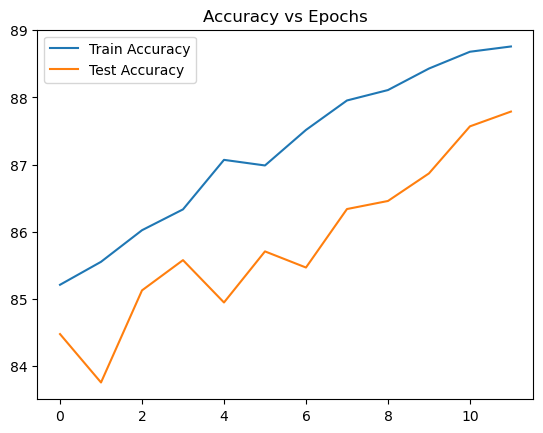

In [26]:
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.legend()
plt.title("Accuracy vs Epochs")
plt.show()


In [28]:
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = outputs.max(1)
        y_true += labels.cpu().tolist()
        y_pred += preds.cpu().tolist()


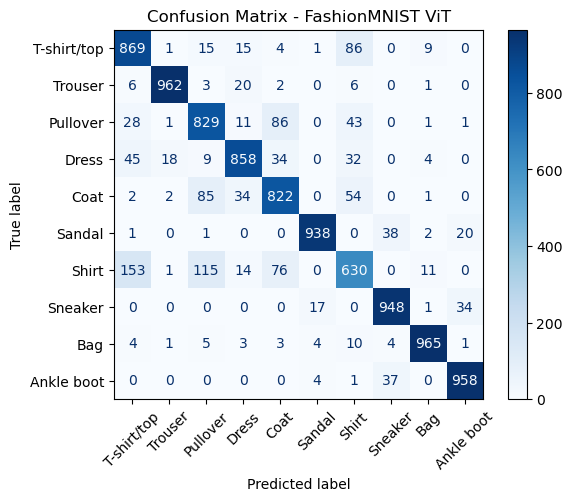

In [29]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - FashionMNIST ViT")
plt.show()


CNN Epoch 1/5: 100%|███████████████████████████████████████████████████████| 938/938 [02:09<00:00,  7.22it/s, loss=0.6]


Epoch 1/5 | Train Acc: 82.81% | Test Acc: 87.25%


CNN Epoch 2/5: 100%|████████████████████████████████████████████████████| 938/938 [02:04<00:00,  7.56it/s, loss=0.0558]


Epoch 2/5 | Train Acc: 89.45% | Test Acc: 89.87%


CNN Epoch 3/5: 100%|█████████████████████████████████████████████████████| 938/938 [02:04<00:00,  7.51it/s, loss=0.311]


Epoch 3/5 | Train Acc: 91.38% | Test Acc: 90.42%


CNN Epoch 4/5: 100%|█████████████████████████████████████████████████████| 938/938 [02:07<00:00,  7.34it/s, loss=0.239]


Epoch 4/5 | Train Acc: 92.31% | Test Acc: 91.09%


CNN Epoch 5/5: 100%|████████████████████████████████████████████████████| 938/938 [02:02<00:00,  7.68it/s, loss=0.0679]


Epoch 5/5 | Train Acc: 93.19% | Test Acc: 91.14%


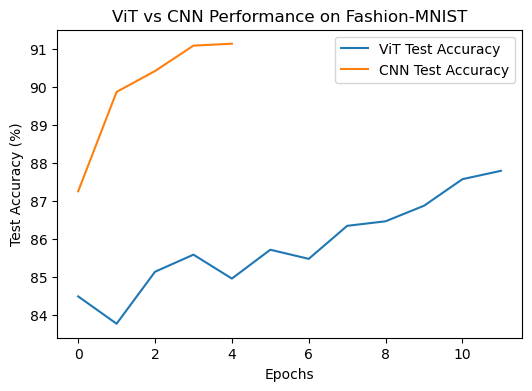

In [32]:
# =====================================================
# Simple CNN Model for Comparison with ViT
# =====================================================

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


cnn_model = SimpleCNN().to(device)
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)
criterion_cnn = nn.CrossEntropyLoss()

epochs_cnn = 5  # quick training for comparison
train_accs_cnn, test_accs_cnn = [], []

for epoch in range(epochs_cnn):
    cnn_model.train()
    correct, total = 0, 0
    loop = tqdm(train_loader, desc=f"CNN Epoch {epoch+1}/{epochs_cnn}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        optimizer_cnn.zero_grad()
        outputs = cnn_model(images)
        loss = criterion_cnn(outputs, labels)
        loss.backward()
        optimizer_cnn.step()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
        loop.set_postfix(loss=loss.item())

    train_acc = 100 * correct / total
    train_accs_cnn.append(train_acc)

    cnn_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = cnn_model(images)
            _, preds = outputs.max(1)
            total += labels.size(0)
            correct += preds.eq(labels).sum().item()
    test_acc = 100 * correct / total
    test_accs_cnn.append(test_acc)
    print(f"Epoch {epoch+1}/{epochs_cnn} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

# ----- Compare Plots -----
plt.figure(figsize=(6,4))
plt.plot(test_accs, label='ViT Test Accuracy')
plt.plot(test_accs_cnn, label='CNN Test Accuracy')
plt.title("ViT vs CNN Performance on Fashion-MNIST")
plt.xlabel("Epochs")
plt.ylabel("Test Accuracy (%)")
plt.legend()
plt.show()


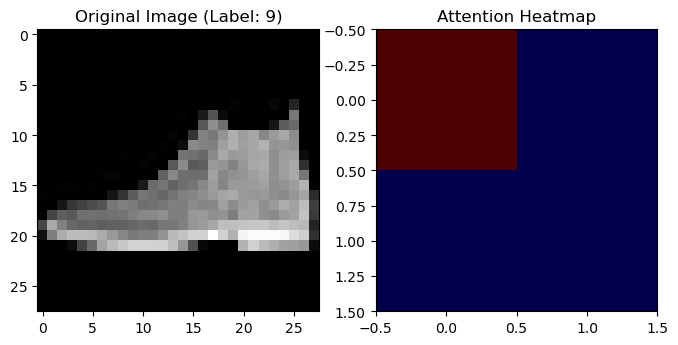

In [34]:
# =====================================================
# Attention Visualization (Bonus Part)
# =====================================================
import numpy as np
import torchvision

def visualize_attention(model, dataset, index=0):
    model.eval()
    image, label = dataset[index]
    input_img = image.unsqueeze(0).to(device)

    with torch.no_grad():
        # Pass image through patch embed and first attention block
        x = model.patch_embed(input_img)
        cls_token = model.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + model.pos_embed
        attn_block = model.blocks[0].attn
        B, N, C = x.shape
        Q = attn_block.query(x).view(B, N, attn_block.num_heads, attn_block.head_dim).transpose(1, 2)
        K = attn_block.key(x).view(B, N, attn_block.num_heads, attn_block.head_dim).transpose(1, 2)
        attn = (Q @ K.transpose(-2, -1)) / (attn_block.head_dim ** 0.5)
        attn = F.softmax(attn, dim=-1)[0, 0, 0, 1:]  # CLS token attention

    attn = attn.reshape(int((x.shape[1]-1)**0.5), int((x.shape[1]-1)**0.5))
    attn = attn.cpu().numpy()

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(image.squeeze(), cmap='gray')
    ax[0].set_title(f"Original Image (Label: {label})")
    ax[1].imshow(image.squeeze(), cmap='gray')
    ax[1].imshow(attn, cmap='jet', alpha=0.6)
    ax[1].set_title("Attention Heatmap")
    plt.show()

# Example: visualize attention for one test image
visualize_attention(model, test_dataset, index=0)


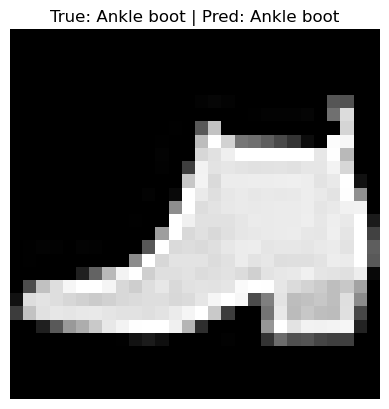

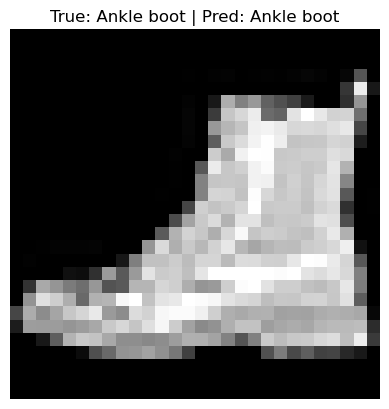

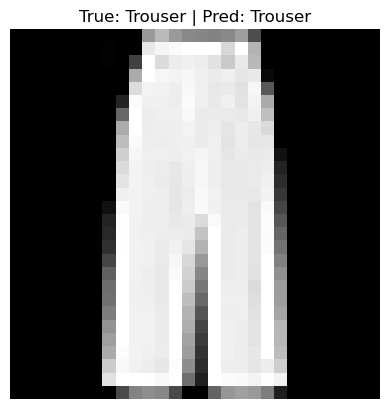

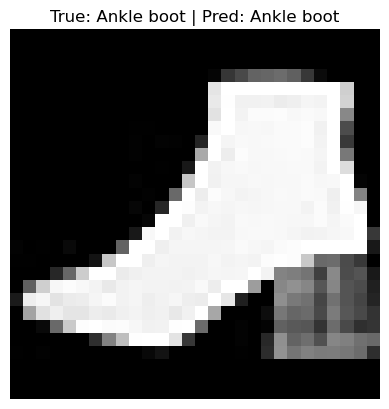

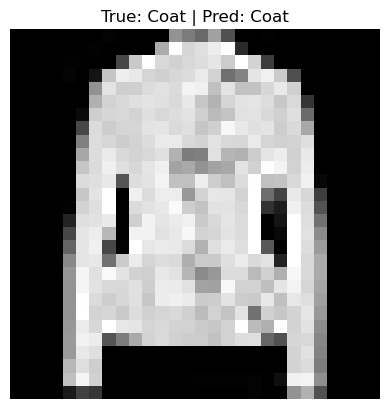

In [36]:
import torch
import matplotlib.pyplot as plt
import random

# pick random 5 test images
indices = random.sample(range(len(test_dataset)), 5)
model.eval()

for idx in indices:
    image, label = test_dataset[idx]
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        pred = output.argmax(dim=1).item()

    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"True: {test_dataset.classes[label]} | Pred: {test_dataset.classes[pred]}")
    plt.axis('off')
    plt.show()
